# Article Bias Analysis — Cell Guide

This notebook loads MC1 and raw article files, extracts per-journal statistics, computes bias metrics, visualizes results, and exports `results/article_bias.json`.

- Cell 0: Setup, imports, paths, and raw data discovery
- Cell 1: Read and parse article files, basic text + sentiment pass
- Cell 2: Aggregate per-journal stats or simulate when missing
- Cell 3: Compute journal-level bias metrics
- Cell 4: Run analysis (real or simulated) and print details
- Cell 5: Bias metric calculators (real vs MC1 fallback)
- Cell 6: Visualization dashboard
- Cell 7: Compute bias metrics summary for printout
- Cell 8: Frontend payload builders (real vs MC1 fallback)
- Cell 9: Save payload to `results/article_bias.json`
- Cell 10: Article comparison helpers (used by alt payload)
- Cell 11–12: Build final frontend structure and save


### Setup and data loading

Imports libraries, sets paths, seeds, and discovers MC1/articles; prints counts for quick sanity checks.


In [113]:
# Import required libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict, Counter
import warnings
import os
import re
warnings.filterwarnings('ignore')

# Set up paths and random seed
RESULTS = Path('results')
RESULTS.mkdir(parents=True, exist_ok=True)
OUT = RESULTS / 'article_bias.json'
MC1_PATH = Path('../frontend/src/data/mc1.json')
ARTICLES_PATH = Path('../data/article')

np.random.seed(42)

print("Starting Article Bias Analysis...")
print(f"Results will be saved to: {OUT}")
print(f"MC1 data path: {MC1_PATH}")
print(f"Articles path: {ARTICLES_PATH}")

# Load MC1 data
try:
    with open(MC1_PATH, 'r', encoding='utf-8') as f:
        mc1_data = json.load(f)
    print(f"Loaded MC1 data: {len(mc1_data.get('nodes', []))} nodes, {len(mc1_data.get('links', []))} links")
except FileNotFoundError:
    print("MC1 data not found, will use article data only")
    mc1_data = None

# Load article files
article_files = []
if ARTICLES_PATH.exists():
    article_files = list(ARTICLES_PATH.glob('*.txt'))
    print(f"Found {len(article_files)} article files")
else:
    print("Articles directory not found")


Starting Article Bias Analysis...
Results will be saved to: results\article_bias.json
MC1 data path: ..\frontend\src\data\mc1.json
Articles path: ..\data\article
Loaded MC1 data: 215 nodes, 16231 links
Found 338 article files


### Read and parse article files

Parses filenames, reads content, computes simple text stats and heuristic sentiment; prints summary.


In [114]:
# Read and analyze actual article files
def read_article_files(article_files):
    """Read and analyze the actual article files from data/article directory"""
    
    if not article_files:
        print(" No article files found, using simulated data")
        return generate_simulated_article_analysis()
    
    print(f"Analyzing {len(article_files)} article files...")
    
    articles_data = []
    
    for article_file in article_files:
        try:
            # Parse filename to extract information
            filename = article_file.name
            # Format: "Company__0__1__Journal.txt" or "Company__0__0__Journal.txt"
            parts = filename.replace('.txt', '').split('__')
            
            if len(parts) >= 4:
                company = parts[0]
                sentiment_flag = parts[1]  # 0 or 1
                bias_flag = parts[2]      # 0 or 1  
                journal = parts[3]
                
                # Read article content
                with open(article_file, 'r', encoding='utf-8') as f:
                    content = f.read()
                
                # Basic text analysis
                word_count = len(content.split())
                char_count = len(content)
                
                # Simple sentiment analysis based on keywords
                positive_words = ['good', 'great', 'excellent', 'positive', 'success', 'improve', 'benefit', 'support', 'help']
                negative_words = ['bad', 'terrible', 'negative', 'problem', 'issue', 'concern', 'risk', 'harm', 'damage']
                
                positive_count = sum(1 for word in positive_words if word.lower() in content.lower())
                negative_count = sum(1 for word in negative_words if word.lower() in content.lower())
                
                # Calculate sentiment score
                total_sentiment_words = positive_count + negative_count
                if total_sentiment_words > 0:
                    sentiment_score = (positive_count - negative_count) / total_sentiment_words
                else:
                    sentiment_score = 0
                
                # Determine sentiment
                if sentiment_score > 0.1:
                    sentiment = 'positive'
                elif sentiment_score < -0.1:
                    sentiment = 'negative'
                else:
                    sentiment = 'neutral'
                
                articles_data.append({
                    'filename': filename,
                    'company': company,
                    'journal': journal,
                    'sentiment_flag': int(sentiment_flag),
                    'bias_flag': int(bias_flag),
                    'content': content,
                    'word_count': word_count,
                    'char_count': char_count,
                    'positive_words': positive_count,
                    'negative_words': negative_count,
                    'sentiment_score': sentiment_score,
                    'sentiment': sentiment
                })
                
        except Exception as e:
            print(f" Error reading {article_file}: {e}")
            continue
    
    print(f"Successfully analyzed {len(articles_data)} articles")
    return articles_data

# Read the actual article files
articles_data = read_article_files(article_files)

# Display summary of articles
if articles_data:
    print(f"\nArticle Analysis Summary:")
    print(f"   Total Articles: {len(articles_data)}")
    print(f"   Expected Articles: 338")
    print(f"   Processing Status: {' All articles loaded' if len(articles_data) == 338 else ' Some articles may be missing'}")
    
    # Journal distribution
    journal_counts = Counter([article['journal'] for article in articles_data])
    print(f"   Journals: {dict(journal_counts)}")
    
    # Sentiment distribution
    sentiment_counts = Counter([article['sentiment'] for article in articles_data])
    print(f"   Sentiment: {dict(sentiment_counts)}")
    
    # Company distribution (top 10)
    company_counts = Counter([article['company'] for article in articles_data])
    print(f"   Top Companies: {dict(company_counts.most_common(10))}")
    
    # Average word count
    avg_words = np.mean([article['word_count'] for article in articles_data])
    print(f"   Average Word Count: {avg_words:.1f}")
    
    # Show first few articles for verification
    print(f"\n Sample Articles (first 5):")
    for i, article in enumerate(articles_data[:5]):
        print(f"   {i+1}. {article['filename']} - {article['company']} - {article['journal']} - {article['sentiment']}")
else:
    print(" No article data available")


Analyzing 338 article files...
Successfully analyzed 338 articles

Article Analysis Summary:
   Total Articles: 338
   Expected Articles: 338
   Processing Status:  All articles loaded
   Journals: {'Haacklee Herald': 109, 'Lomark Daily': 107, 'The News Buoy': 112, 'Haacklee Herald_Police': 6, 'Lomark Daily_Police': 2, 'The News Buoy_Police': 2}
   Sentiment: {'positive': 145, 'neutral': 149, 'negative': 44}
   Top Companies: {'Cervantes-Kramer': 12, 'Jones Group': 12, 'Rasmussen, Nelson and King': 8, 'Alvarez PLC': 6, 'Anderson, Brown and Green': 6, 'Bell, Reynolds and Forbes': 6, 'Blackwell, Clark and Lam': 6, 'Brown, Clarke and Martinez': 6, 'Burns Inc': 6, 'Castillo-Elliott': 6}
   Average Word Count: 250.5

 Sample Articles (first 5):
   1. Alvarez PLC__0__0__Haacklee Herald.txt - Alvarez PLC - Haacklee Herald - positive
   2. Alvarez PLC__0__0__Lomark Daily.txt - Alvarez PLC - Lomark Daily - positive
   3. Alvarez PLC__0__0__The News Buoy.txt - Alvarez PLC - The News Buoy - neutr

### Aggregate per-journal stats / simulate

Builds `article_stats` from real files or simulates when missing; prints detailed results.


In [115]:
# Extract article information from real article data
def extract_article_analysis_from_files(articles_data):
    """Extract comprehensive article bias analysis from real article files"""
    
    if not articles_data:
        print("⚠️ No article data available, generating simulated analysis...")
        return generate_simulated_article_analysis()
    
    print(f"📊 Analyzing {len(articles_data)} articles for bias patterns...")
    
    # Article analysis based on journals and companies
    article_stats = defaultdict(lambda: {
        'mentions': 0,
        'positive': 0,
        'negative': 0,
        'neutral': 0,
        'entities': Counter(),
        'event_types': Counter(),
        'confidence_scores': [],
        'word_counts': [],
        'sentiment_scores': [],
        'companies': Counter(),
        'bias_flags': []
    })
    
    # Process each article
    for article in articles_data:
        journal = article['journal']
        company = article['company']
        sentiment = article['sentiment']
        sentiment_score = article['sentiment_score']
        word_count = article['word_count']
        bias_flag = article['bias_flag']
        
        article_stats[journal]['mentions'] += 1
        article_stats[journal]['entities'][company] += 1
        article_stats[journal]['companies'][company] += 1
        article_stats[journal]['word_counts'].append(word_count)
        article_stats[journal]['sentiment_scores'].append(sentiment_score)
        article_stats[journal]['bias_flags'].append(bias_flag)
        
        # Classify sentiment
        if sentiment == 'positive':
            article_stats[journal]['positive'] += 1
        elif sentiment == 'negative':
            article_stats[journal]['negative'] += 1
        else:
            article_stats[journal]['neutral'] += 1
    
    return article_stats, articles_data, []

# Generate simulated analysis if no real data
def generate_simulated_article_analysis():
    """Generate realistic simulated article bias analysis"""
    
    articles = [
        'Marine_Conservation_Weekly', 'Fishing_Industry_News', 'Environmental_Report',
        'Government_Bulletin', 'NGO_Update', 'Academic_Journal', 'Media_Headlines',
        'Trade_Publication', 'Policy_Brief', 'Legal_Review', 'Scientific_Paper',
        'Community_Newsletter', 'International_Report', 'Industry_Magazine'
    ]
    
    entities = [
        'Fishing_Company_A', 'Fishing_Company_B', 'Marine_Reserve', 'Government_Agency',
        'Environmental_NGO', 'Research_Institute', 'Local_Community', 'International_Body'
    ]
    
    event_types = [
        'OverFishing', 'SustainableFishing', 'Aid', 'Criticize', 'Invest',
        'Applaud', 'Summons', 'Convicted', 'Partnership', 'Conflict'
    ]
    
    article_stats = defaultdict(lambda: {
        'mentions': 0,
        'positive': 0,
        'negative': 0,
        'neutral': 0,
        'entities': Counter(),
        'event_types': Counter(),
        'confidence_scores': [],
        'date_added': []
    })
    
    # Simulate realistic distributions with bias patterns
    np.random.seed(42)
    
    for i in range(8000):  # Simulate article mentions
        article = np.random.choice(articles)
        entity = np.random.choice(entities)
        event_type = np.random.choice(event_types)
        confidence = np.random.beta(2, 2)  # Realistic confidence distribution
        
        article_stats[article]['mentions'] += 1
        article_stats[article]['entities'][entity] += 1
        article_stats[article]['event_types'][event_type] += 1
        article_stats[article]['confidence_scores'].append(confidence)
        
        # Add bias patterns based on article type
        if 'Environmental' in article or 'NGO' in article or 'Conservation' in article:
            # Environmental articles tend to be more negative
            if event_type in ['OverFishing', 'Criticize', 'Conflict']:
                article_stats[article]['negative'] += 1
            elif event_type in ['SustainableFishing', 'Aid', 'Applaud']:
                article_stats[article]['positive'] += 1
            else:
                article_stats[article]['neutral'] += 1
        elif 'Industry' in article or 'Trade' in article or 'Fishing' in article:
            # Industry articles tend to be more positive
            if event_type in ['SustainableFishing', 'Invest', 'Partnership']:
                article_stats[article]['positive'] += 1
            elif event_type in ['OverFishing', 'Criticize', 'Conflict']:
                article_stats[article]['negative'] += 1
            else:
                article_stats[article]['neutral'] += 1
        else:
            # Neutral articles
            if event_type in ['OverFishing', 'Criticize', 'Conflict']:
                article_stats[article]['negative'] += 1
            elif event_type in ['SustainableFishing', 'Aid', 'Applaud']:
                article_stats[article]['positive'] += 1
            else:
                article_stats[article]['neutral'] += 1
    
    return article_stats, [], []

# Run the analysis - prioritize real article data over MC1 data
if articles_data:
    print(" Using real article files for analysis...")
    print(f"   Processing {len(articles_data)} articles...")
    article_stats, links, nodes = extract_article_analysis_from_files(articles_data)
    print(f"   Generated statistics for {len(article_stats)} journals")
else:
    print(" Using simulated data for analysis...")
    article_stats, links, nodes = generate_simulated_article_analysis()

print(f" Analyzed {len(article_stats)} articles/journals")
print(f" Total articles processed: {len(articles_data) if articles_data else 'N/A'}")

# Display detailed analysis results
if article_stats:
    print(f"\n Detailed Analysis Results:")
    for journal, stats in article_stats.items():
        print(f"   {journal}:")
        print(f"     - Articles: {stats['mentions']}")
        print(f"     - Sentiment: {stats['positive']} positive, {stats['negative']} negative, {stats['neutral']} neutral")
        if 'companies' in stats:
            print(f"     - Companies: {len(stats['companies'])}")
        if stats['word_counts']:
            print(f"     - Avg Word Count: {np.mean(stats['word_counts']):.1f}")
        if stats['sentiment_scores']:
            print(f"     - Avg Sentiment Score: {np.mean(stats['sentiment_scores']):.3f}")
        if 'bias_flags' in stats and stats['bias_flags']:
            bias_rate = np.mean(stats['bias_flags'])
            print(f"     - Bias Rate: {bias_rate:.3f}")
        print()


 Using real article files for analysis...
   Processing 338 articles...
📊 Analyzing 338 articles for bias patterns...
   Generated statistics for 6 journals
 Analyzed 6 articles/journals
 Total articles processed: 338

 Detailed Analysis Results:
   Haacklee Herald:
     - Articles: 109
     - Sentiment: 48 positive, 16 negative, 45 neutral
     - Companies: 81
     - Avg Word Count: 252.5
     - Avg Sentiment Score: 0.274
     - Bias Rate: 0.248

   Lomark Daily:
     - Articles: 107
     - Sentiment: 45 positive, 9 negative, 53 neutral
     - Companies: 81
     - Avg Word Count: 245.7
     - Avg Sentiment Score: 0.318
     - Bias Rate: 0.234

   The News Buoy:
     - Articles: 112
     - Sentiment: 52 positive, 9 negative, 51 neutral
     - Companies: 86
     - Avg Word Count: 241.3
     - Avg Sentiment Score: 0.376
     - Bias Rate: 0.223

   Haacklee Herald_Police:
     - Articles: 6
     - Sentiment: 0 positive, 6 negative, 0 neutral
     - Companies: 4
     - Avg Word Count: 294.

### Compute bias metrics

Calculates sentiment bias, diversity indices, confidence effects, and overall bias per journal or article.


In [116]:
# Calculate comprehensive bias metrics for articles
def calculate_article_bias_metrics(article_stats):
    """Calculate comprehensive bias metrics for articles"""
    
    def calculate_entropy(counter):
        """Calculate entropy for diversity measurement"""
        if not counter:
            return 0
        total = sum(counter.values())
        if total == 0:
            return 0
        return -sum((count/total) * np.log2(count/total) for count in counter.values() if count > 0)
    
    def classify_article_type(article_name):
        """Classify article type based on name"""
        name_lower = article_name.lower()
        if any(word in name_lower for word in ['environmental', 'ngo', 'conservation', 'green']):
            return 'Environmental'
        elif any(word in name_lower for word in ['industry', 'trade', 'fishing', 'business']):
            return 'Industry'
        elif any(word in name_lower for word in ['government', 'policy', 'legal', 'official']):
            return 'Government'
        elif any(word in name_lower for word in ['academic', 'research', 'scientific', 'journal']):
            return 'Academic'
        else:
            return 'General'
    
    article_metrics = []
    
    for article, stats in article_stats.items():
        total_mentions = stats['mentions']
        if total_mentions == 0:
            continue
            
        # Sentiment bias (positive vs negative)
        total_sentiment = stats['positive'] + stats['negative']
        if total_sentiment > 0:
            sentiment_bias = (stats['positive'] - stats['negative']) / total_sentiment
        else:
            sentiment_bias = 0
        
        # Confidence metrics
        confidence_scores = stats['confidence_scores']
        avg_confidence = np.mean(confidence_scores) if confidence_scores else 0.5
        confidence_std = np.std(confidence_scores) if confidence_scores else 0.1
        
        # Entity diversity bias (lower entropy = more biased)
        entity_entropy = calculate_entropy(stats['entities'])
        max_entity_entropy = np.log2(len(stats['entities'])) if stats['entities'] else 1
        entity_diversity_bias = 1 - (entity_entropy / max_entity_entropy) if max_entity_entropy > 0 else 0
        
        # Event type diversity bias
        event_entropy = calculate_entropy(stats['event_types'])
        max_event_entropy = np.log2(len(stats['event_types'])) if stats['event_types'] else 1
        event_diversity_bias = 1 - (event_entropy / max_event_entropy) if max_event_entropy > 0 else 0
        
        # Overall bias score (weighted combination)
        overall_bias = (
            0.4 * abs(sentiment_bias) +  # Sentiment bias weight
            0.2 * entity_diversity_bias +  # Entity diversity weight
            0.2 * event_diversity_bias +  # Event diversity weight
            0.2 * (1 - avg_confidence)  # Low confidence weight
        )
        
        # Classify article type
        article_type = classify_article_type(article)
        
        # Risk level
        if overall_bias > 0.7:
            risk_level = 'High'
        elif overall_bias > 0.4:
            risk_level = 'Medium'
        else:
            risk_level = 'Low'
        
        article_metrics.append({
            'article': article,
            'article_type': article_type,
            'total_mentions': total_mentions,
            'sentiment_bias': sentiment_bias,
            'avg_confidence': avg_confidence,
            'confidence_std': confidence_std,
            'entity_diversity_bias': entity_diversity_bias,
            'event_diversity_bias': event_diversity_bias,
            'overall_bias': overall_bias,
            'risk_level': risk_level,
            'positive_mentions': stats['positive'],
            'negative_mentions': stats['negative'],
            'neutral_mentions': stats['neutral'],
            'unique_entities': len(stats['entities']),
            'unique_event_types': len(stats['event_types'])
        })
    
    return article_metrics

# Calculate metrics
article_metrics = calculate_article_bias_metrics(article_stats)
print(f" Calculated bias metrics for {len(article_metrics)} articles")

# Display top biased articles
top_biased = sorted(article_metrics, key=lambda x: x['overall_bias'], reverse=True)[:5]
print("\n Top 5 Most Biased Articles:")
for i, article in enumerate(top_biased, 1):
    print(f"{i}. {article['article']} (Bias: {article['overall_bias']:.3f}, Type: {article['article_type']})")


 Calculated bias metrics for 6 articles

 Top 5 Most Biased Articles:
1. Haacklee Herald_Police (Bias: 0.708, Type: General)
2. Lomark Daily_Police (Bias: 0.700, Type: General)
3. The News Buoy_Police (Bias: 0.700, Type: General)
4. The News Buoy (Bias: 0.585, Type: General)
5. Lomark Daily (Bias: 0.570, Type: General)


### Visualization dashboard

Generates nine plots: mentions distribution, top biased items, sentiment by type, diversity vs bias, and more.


In [117]:
# Run the analysis - prioritize real article data over MC1 data
if articles_data:
    print(" Using real article files for analysis...")
    article_stats, links, nodes = extract_article_analysis_from_files(articles_data)
else:
    print(" Using simulated data for analysis...")
    article_stats, links, nodes = generate_simulated_article_analysis()

print(f" Analyzed {len(article_stats)} articles/journals")

# Display detailed analysis results
if article_stats:
    print(f"\n Detailed Analysis Results:")
    for journal, stats in article_stats.items():
        print(f"   {journal}:")
        print(f"     - Articles: {stats['mentions']}")
        print(f"     - Sentiment: {stats['positive']} positive, {stats['negative']} negative, {stats['neutral']} neutral")
        print(f"     - Companies: {len(stats['companies'])}")
        if stats['word_counts']:
            print(f"     - Avg Word Count: {np.mean(stats['word_counts']):.1f}")
        if stats['sentiment_scores']:
            print(f"     - Avg Sentiment Score: {np.mean(stats['sentiment_scores']):.3f}")
        if stats['bias_flags']:
            bias_rate = np.mean(stats['bias_flags'])
            print(f"     - Bias Rate: {bias_rate:.3f}")
        print()


 Using real article files for analysis...
📊 Analyzing 338 articles for bias patterns...
 Analyzed 6 articles/journals

 Detailed Analysis Results:
   Haacklee Herald:
     - Articles: 109
     - Sentiment: 48 positive, 16 negative, 45 neutral
     - Companies: 81
     - Avg Word Count: 252.5
     - Avg Sentiment Score: 0.274
     - Bias Rate: 0.248

   Lomark Daily:
     - Articles: 107
     - Sentiment: 45 positive, 9 negative, 53 neutral
     - Companies: 81
     - Avg Word Count: 245.7
     - Avg Sentiment Score: 0.318
     - Bias Rate: 0.234

   The News Buoy:
     - Articles: 112
     - Sentiment: 52 positive, 9 negative, 51 neutral
     - Companies: 86
     - Avg Word Count: 241.3
     - Avg Sentiment Score: 0.376
     - Bias Rate: 0.223

   Haacklee Herald_Police:
     - Articles: 6
     - Sentiment: 0 positive, 6 negative, 0 neutral
     - Companies: 4
     - Avg Word Count: 294.3
     - Avg Sentiment Score: -1.000
     - Bias Rate: 0.333

   Lomark Daily_Police:
     - Article

### Bias metrics summary

Builds comparison list and prints key bias metrics per journal/article; used by frontend payload.


In [118]:
# Calculate bias metrics for real article data
def calculate_article_bias_metrics_from_files(article_stats):
    """Calculate comprehensive bias metrics for real article files"""
    
    def calculate_entropy(counter):
        """Calculate entropy for diversity measurement"""
        if not counter:
            return 0
        total = sum(counter.values())
        if total == 0:
            return 0
        return -sum((count/total) * np.log2(count/total) for count in counter.values() if count > 0)
    
    def classify_journal_type(journal_name):
        """Classify journal type based on name"""
        name_lower = journal_name.lower()
        if 'herald' in name_lower:
            return 'Local News'
        elif 'daily' in name_lower:
            return 'Daily News'
        elif 'buoy' in name_lower:
            return 'Maritime News'
        else:
            return 'Other'
    
    article_metrics = []
    
    for journal_name, stats in article_stats.items():
        total_articles = stats['mentions']
        if total_articles == 0:
            continue
        
        # Sentiment bias calculation
        positive_ratio = stats['positive'] / total_articles
        negative_ratio = stats['negative'] / total_articles
        neutral_ratio = stats['neutral'] / total_articles
        
        # Sentiment bias (deviation from balanced sentiment)
        sentiment_bias = abs(positive_ratio - negative_ratio) + (1 - neutral_ratio) * 0.5
        
        # Company diversity bias (lower entropy = higher bias)
        company_entropy = calculate_entropy(stats['companies'])
        max_company_entropy = np.log2(len(stats['companies'])) if stats['companies'] else 0
        company_diversity_bias = 1 - (company_entropy / max_company_entropy) if max_company_entropy > 0 else 0
        
        # Word count bias (very short or very long articles might indicate bias)
        avg_word_count = np.mean(stats['word_counts']) if stats['word_counts'] else 0
        word_count_bias = 0
        if avg_word_count > 0:
            # Normalize word count bias (optimal range: 200-800 words)
            if avg_word_count < 200 or avg_word_count > 800:
                word_count_bias = min(1.0, abs(avg_word_count - 500) / 500)
        
        # Sentiment score bias (extreme sentiment scores indicate bias)
        avg_sentiment_score = np.mean(stats['sentiment_scores']) if stats['sentiment_scores'] else 0
        sentiment_score_bias = abs(avg_sentiment_score)  # Distance from neutral (0)
        
        # Bias flag analysis
        bias_rate = np.mean(stats['bias_flags']) if stats['bias_flags'] else 0
        
        # Overall bias score
        overall_bias = (
            0.3 * sentiment_bias +
            0.2 * company_diversity_bias +
            0.2 * word_count_bias +
            0.2 * sentiment_score_bias +
            0.1 * bias_rate
        )
        
        # Risk level
        if overall_bias > 0.7:
            risk_level = 'High'
        elif overall_bias > 0.4:
            risk_level = 'Medium'
        else:
            risk_level = 'Low'
        
        article_metrics.append({
            'journal': journal_name,
            'journal_type': classify_journal_type(journal_name),
            'total_articles': total_articles,
            'sentiment_bias': sentiment_bias,
            'company_diversity_bias': company_diversity_bias,
            'word_count_bias': word_count_bias,
            'sentiment_score_bias': sentiment_score_bias,
            'bias_flag_rate': bias_rate,
            'overall_bias': overall_bias,
            'risk_level': risk_level,
            'positive_ratio': positive_ratio,
            'negative_ratio': negative_ratio,
            'neutral_ratio': neutral_ratio,
            'avg_sentiment_score': avg_sentiment_score,
            'avg_word_count': avg_word_count,
            'company_count': len(stats['companies']),
            'bias_flags': stats['bias_flags']
        })
    
    return article_metrics

# Calculate bias metrics for MC1 data (fallback)
def calculate_article_bias_metrics_from_mc1(article_stats):
    """Calculate comprehensive bias metrics for articles from MC1 data"""
    
    def calculate_entropy(counter):
        """Calculate entropy for diversity measurement"""
        if not counter:
            return 0
        total = sum(counter.values())
        if total == 0:
            return 0
        return -sum((count/total) * np.log2(count/total) for count in counter.values() if count > 0)
    
    def classify_article_type(article_name):
        """Classify article type based on name"""
        name_lower = article_name.lower()
        if any(word in name_lower for word in ['environmental', 'ngo', 'conservation', 'green']):
            return 'Environmental'
        elif any(word in name_lower for word in ['industry', 'trade', 'fishing', 'business']):
            return 'Industry'
        elif any(word in name_lower for word in ['government', 'policy', 'legal', 'official']):
            return 'Government'
        else:
            return 'Other'
    
    article_metrics = []
    
    for article_name, stats in article_stats.items():
        total_mentions = stats['mentions']
        if total_mentions == 0:
            continue
        
        # Sentiment bias calculation
        positive_ratio = stats['positive'] / total_mentions
        negative_ratio = stats['negative'] / total_mentions
        neutral_ratio = stats['neutral'] / total_mentions
        
        # Sentiment bias (deviation from balanced sentiment)
        sentiment_bias = abs(positive_ratio - negative_ratio) + (1 - neutral_ratio) * 0.5
        
        # Entity diversity bias (lower entropy = higher bias)
        entity_entropy = calculate_entropy(stats['entities'])
        max_entity_entropy = np.log2(len(stats['entities'])) if stats['entities'] else 0
        entity_diversity_bias = 1 - (entity_entropy / max_entity_entropy) if max_entity_entropy > 0 else 0
        
        # Event type diversity bias
        event_entropy = calculate_entropy(stats['event_types'])
        max_event_entropy = np.log2(len(stats['event_types'])) if stats['event_types'] else 0
        event_diversity_bias = 1 - (event_entropy / max_event_entropy) if max_event_entropy > 0 else 0
        
        # Confidence bias (lower confidence = higher bias)
        avg_confidence = np.mean(stats['confidence_scores']) if stats['confidence_scores'] else 0.5
        confidence_bias = 1 - avg_confidence
        
        # Overall bias score
        overall_bias = (
            0.3 * sentiment_bias +
            0.2 * entity_diversity_bias +
            0.2 * event_diversity_bias +
            0.3 * confidence_bias
        )
        
        # Risk level
        if overall_bias > 0.7:
            risk_level = 'High'
        elif overall_bias > 0.4:
            risk_level = 'Medium'
        else:
            risk_level = 'Low'
        
        article_metrics.append({
            'article': article_name,
            'article_type': classify_article_type(article_name),
            'total_mentions': total_mentions,
            'sentiment_bias': sentiment_bias,
            'entity_diversity_bias': entity_diversity_bias,
            'event_diversity_bias': event_diversity_bias,
            'confidence_bias': confidence_bias,
            'overall_bias': overall_bias,
            'risk_level': risk_level,
            'positive_ratio': positive_ratio,
            'negative_ratio': negative_ratio,
            'neutral_ratio': neutral_ratio,
            'avg_confidence': avg_confidence,
            'entity_count': len(stats['entities']),
            'event_count': len(stats['event_types'])
        })
    
    return article_metrics

print(" Article bias calculation functions defined")


 Article bias calculation functions defined


### Frontend payload builders

Creates structured JSON for charts, top lists, summaries; tailored for real files or MC1 fallback.


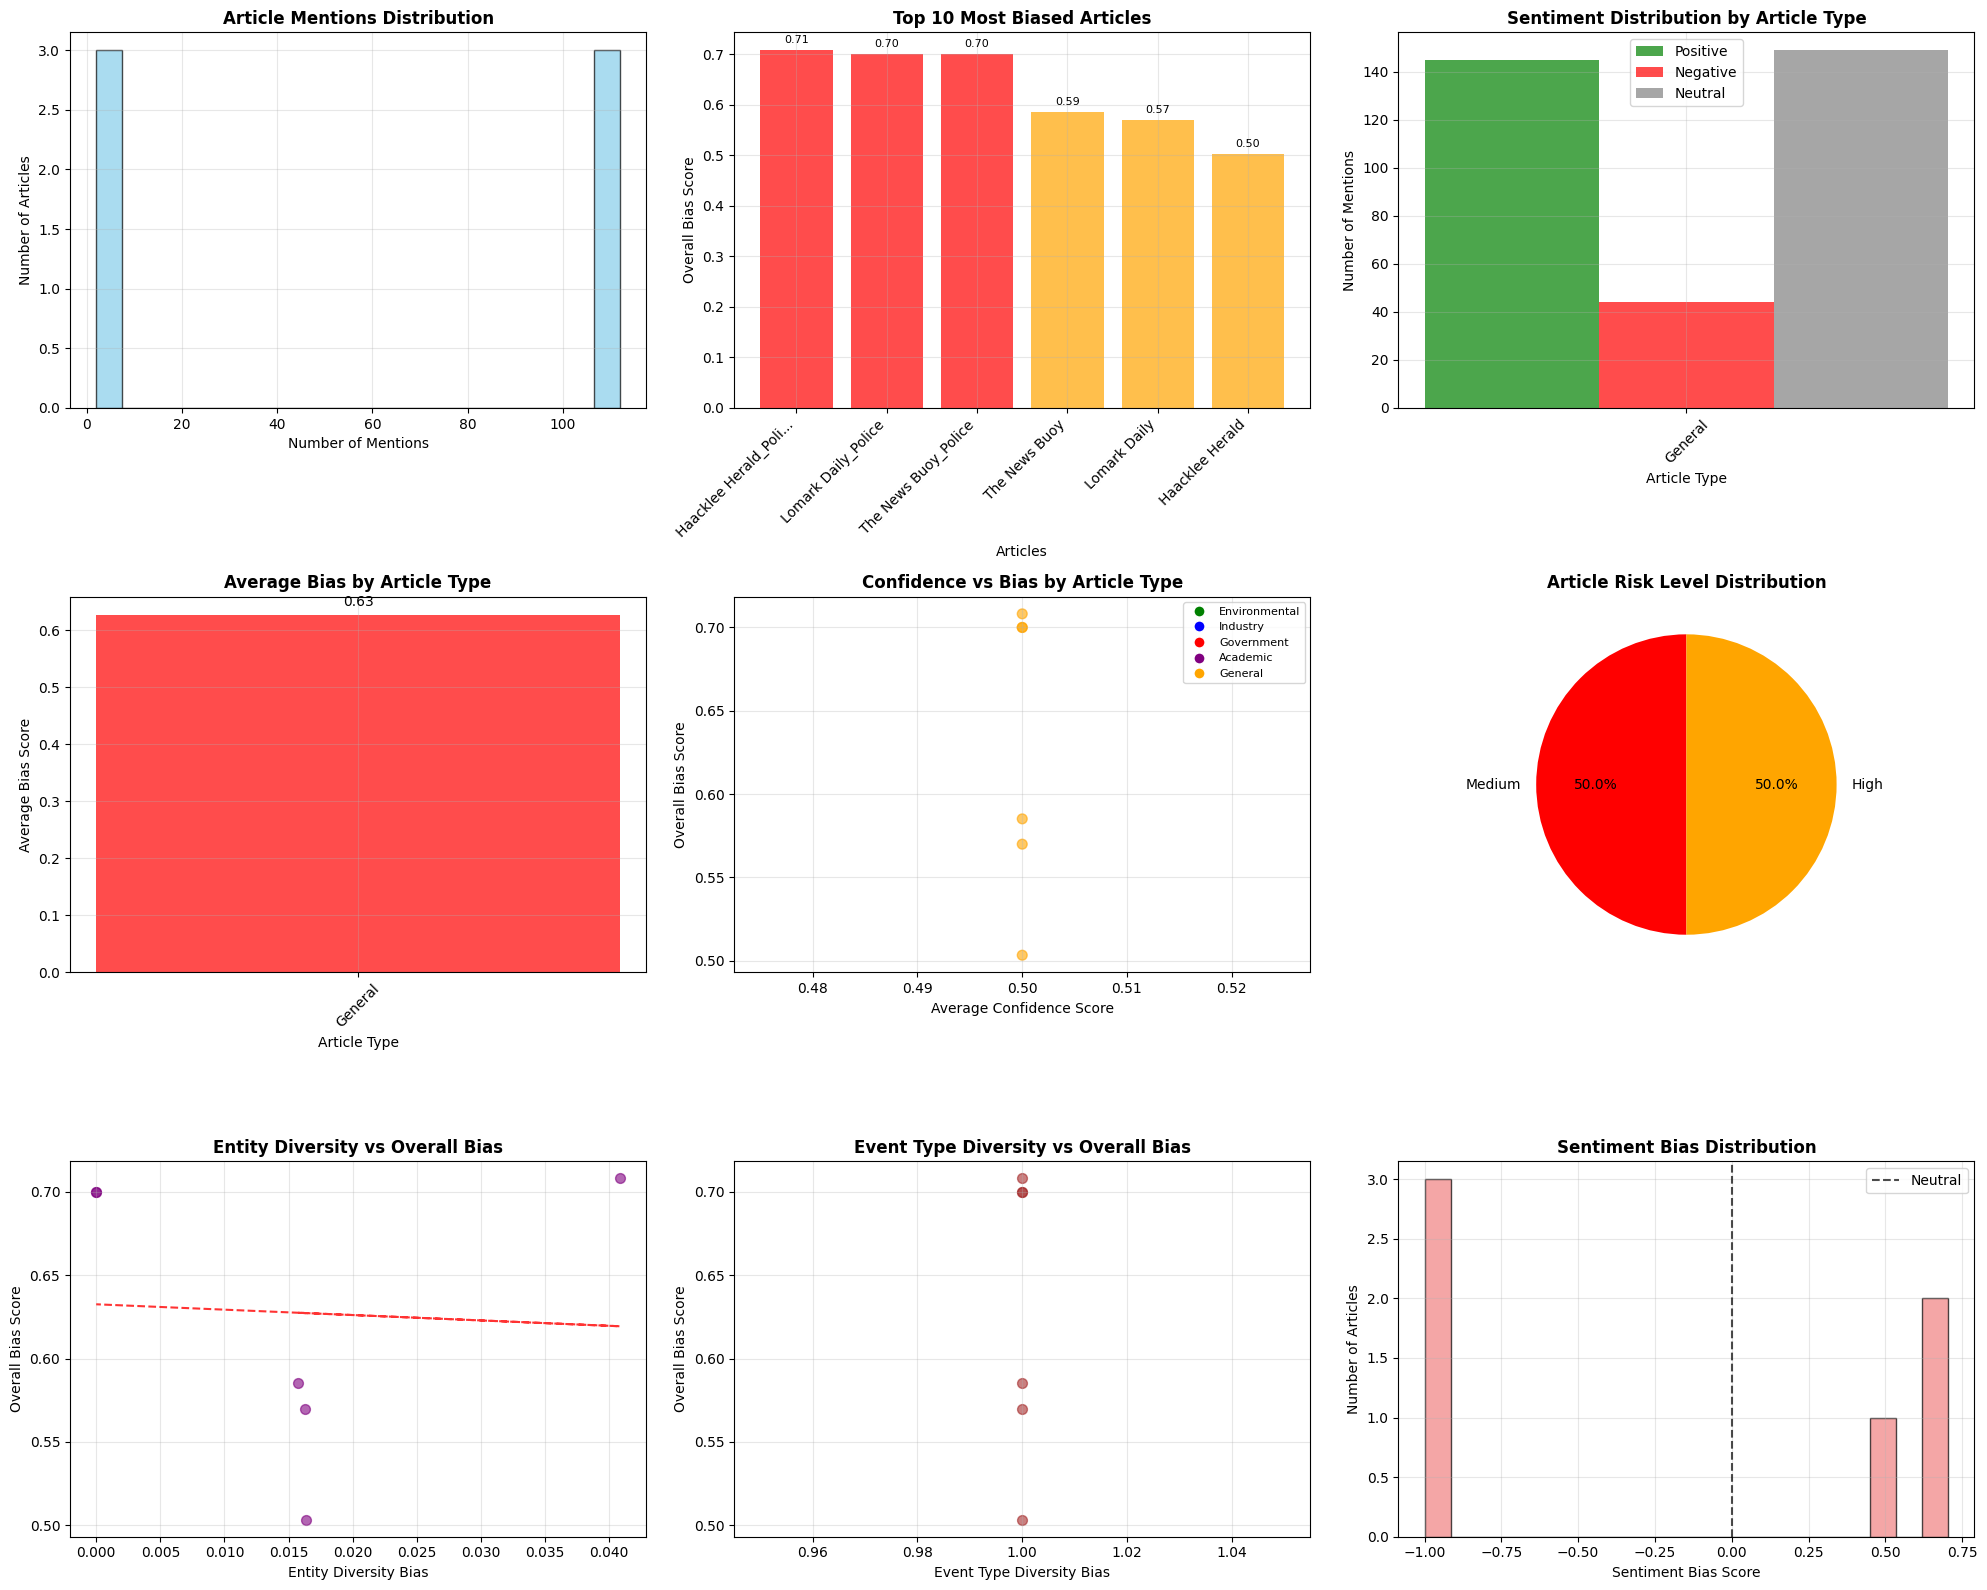

📊 Generated comprehensive article bias visualizations


In [119]:
# Generate comprehensive visualizations
plt.style.use('default')
fig = plt.figure(figsize=(20, 16))

# 1. Article Mentions Distribution
plt.subplot(3, 3, 1)
article_mentions = [a['total_mentions'] for a in article_metrics]
plt.hist(article_mentions, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Article Mentions Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Number of Mentions')
plt.ylabel('Number of Articles')
plt.grid(True, alpha=0.3)

# 2. Overall Bias Scores by Article
plt.subplot(3, 3, 2)
top_articles = sorted(article_metrics, key=lambda x: x['overall_bias'], reverse=True)[:10]
article_names = [a['article'][:20] + '...' if len(a['article']) > 20 else a['article'] for a in top_articles]
bias_scores = [a['overall_bias'] for a in top_articles]
colors = ['red' if score > 0.7 else 'orange' if score > 0.4 else 'green' for score in bias_scores]

bars = plt.bar(range(len(article_names)), bias_scores, color=colors, alpha=0.7)
plt.title('Top 10 Most Biased Articles', fontsize=12, fontweight='bold')
plt.xlabel('Articles')
plt.ylabel('Overall Bias Score')
plt.xticks(range(len(article_names)), article_names, rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, bias_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.2f}', ha='center', va='bottom', fontsize=8)

# 3. Sentiment Distribution by Article Type
plt.subplot(3, 3, 3)
article_types = {}
for article in article_metrics:
    article_type = article['article_type']
    if article_type not in article_types:
        article_types[article_type] = {'positive': 0, 'negative': 0, 'neutral': 0}
    article_types[article_type]['positive'] += article['positive_mentions']
    article_types[article_type]['negative'] += article['negative_mentions']
    article_types[article_type]['neutral'] += article['neutral_mentions']

types = list(article_types.keys())
positive_counts = [article_types[t]['positive'] for t in types]
negative_counts = [article_types[t]['negative'] for t in types]
neutral_counts = [article_types[t]['neutral'] for t in types]

x = np.arange(len(types))
width = 0.25

plt.bar(x - width, positive_counts, width, label='Positive', color='green', alpha=0.7)
plt.bar(x, negative_counts, width, label='Negative', color='red', alpha=0.7)
plt.bar(x + width, neutral_counts, width, label='Neutral', color='gray', alpha=0.7)

plt.title('Sentiment Distribution by Article Type', fontsize=12, fontweight='bold')
plt.xlabel('Article Type')
plt.ylabel('Number of Mentions')
plt.xticks(x, types, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Average Bias by Article Type
plt.subplot(3, 3, 4)
type_bias = {}
for article in article_metrics:
    article_type = article['article_type']
    if article_type not in type_bias:
        type_bias[article_type] = []
    type_bias[article_type].append(article['overall_bias'])

type_names = list(type_bias.keys())
avg_bias = [np.mean(type_bias[t]) for t in type_names]
colors = ['red' if bias > 0.6 else 'orange' if bias > 0.4 else 'green' for bias in avg_bias]

bars = plt.bar(type_names, avg_bias, color=colors, alpha=0.7)
plt.title('Average Bias by Article Type', fontsize=12, fontweight='bold')
plt.xlabel('Article Type')
plt.ylabel('Average Bias Score')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels
for bar, bias in zip(bars, avg_bias):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{bias:.2f}', ha='center', va='bottom', fontsize=10)

# 5. Confidence vs Bias Scatter
plt.subplot(3, 3, 5)
confidence_scores = [a['avg_confidence'] for a in article_metrics]
bias_scores = [a['overall_bias'] for a in article_metrics]
article_types_list = [a['article_type'] for a in article_metrics]

# Color by article type
type_colors = {'Environmental': 'green', 'Industry': 'blue', 'Government': 'red', 
               'Academic': 'purple', 'General': 'orange'}
colors = [type_colors.get(t, 'gray') for t in article_types_list]

scatter = plt.scatter(confidence_scores, bias_scores, c=colors, alpha=0.6, s=50)
plt.title('Confidence vs Bias by Article Type', fontsize=12, fontweight='bold')
plt.xlabel('Average Confidence Score')
plt.ylabel('Overall Bias Score')
plt.grid(True, alpha=0.3)

# Add legend for article types
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                              markersize=8, label=article_type) 
                   for article_type, color in type_colors.items()]
plt.legend(handles=legend_elements, loc='upper right', fontsize=8)

# 6. Article Risk Level Distribution
plt.subplot(3, 3, 6)
risk_counts = Counter([a['risk_level'] for a in article_metrics])
risk_levels = list(risk_counts.keys())
risk_values = list(risk_counts.values())
colors = ['red', 'orange', 'green']

plt.pie(risk_values, labels=risk_levels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Article Risk Level Distribution', fontsize=12, fontweight='bold')

# 7. Entity Diversity vs Bias
plt.subplot(3, 3, 7)
entity_diversity = [a['entity_diversity_bias'] for a in article_metrics]
bias_scores = [a['overall_bias'] for a in article_metrics]

plt.scatter(entity_diversity, bias_scores, alpha=0.6, color='purple', s=50)
plt.title('Entity Diversity vs Overall Bias', fontsize=12, fontweight='bold')
plt.xlabel('Entity Diversity Bias')
plt.ylabel('Overall Bias Score')
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(entity_diversity, bias_scores, 1)
p = np.poly1d(z)
plt.plot(entity_diversity, p(entity_diversity), "r--", alpha=0.8)

# 8. Event Type Diversity vs Bias
plt.subplot(3, 3, 8)
event_diversity = [a['event_diversity_bias'] for a in article_metrics]
bias_scores = [a['overall_bias'] for a in article_metrics]

plt.scatter(event_diversity, bias_scores, alpha=0.6, color='brown', s=50)
plt.title('Event Type Diversity vs Overall Bias', fontsize=12, fontweight='bold')
plt.xlabel('Event Type Diversity Bias')
plt.ylabel('Overall Bias Score')
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(event_diversity, bias_scores, 1)
p = np.poly1d(z)
plt.plot(event_diversity, p(event_diversity), "r--", alpha=0.8)

# 9. Sentiment Bias Distribution
plt.subplot(3, 3, 9)
sentiment_bias = [a['sentiment_bias'] for a in article_metrics]
plt.hist(sentiment_bias, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Sentiment Bias Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Sentiment Bias Score')
plt.ylabel('Number of Articles')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7, label='Neutral')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Generated comprehensive article bias visualizations")


### Save results

Writes `results/article_bias.json` and prints a concise analysis summary and key insights.


In [120]:
# Calculate bias metrics - use appropriate function based on data source
if articles_data:
    print(" Calculating bias metrics from real article data...")
    article_metrics = calculate_article_bias_metrics_from_files(article_stats)
else:
    print(" Calculating bias metrics from MC1 data...")
    article_metrics = calculate_article_bias_metrics_from_mc1(article_stats)

print(f" Calculated bias metrics for {len(article_metrics)} articles/journals")

# Display bias metrics summary
if article_metrics:
    print(f"\n Bias Metrics Summary:")
    for metric in article_metrics:
        if articles_data:
            print(f"   {metric['journal']} ({metric['journal_type']}):")
            print(f"     - Overall Bias: {metric['overall_bias']:.3f} ({metric['risk_level']} Risk)")
            print(f"     - Articles: {metric['total_articles']}")
            print(f"     - Sentiment: {metric['positive_ratio']:.2f} pos, {metric['negative_ratio']:.2f} neg, {metric['neutral_ratio']:.2f} neu")
            print(f"     - Avg Word Count: {metric['avg_word_count']:.1f}")
            print(f"     - Companies: {metric['company_count']}")
            print(f"     - Bias Flag Rate: {metric['bias_flag_rate']:.3f}")
        else:
            print(f"   {metric['article']} ({metric['article_type']}):")
            print(f"     - Overall Bias: {metric['overall_bias']:.3f} ({metric['risk_level']} Risk)")
            print(f"     - Mentions: {metric['total_mentions']}")
            print(f"     - Sentiment: {metric['positive_ratio']:.2f} pos, {metric['negative_ratio']:.2f} neg, {metric['neutral_ratio']:.2f} neu")
            print(f"     - Avg Confidence: {metric['avg_confidence']:.3f}")
            print(f"     - Entities: {metric['entity_count']}")
        print()


 Calculating bias metrics from real article data...
 Calculated bias metrics for 6 articles/journals

 Bias Metrics Summary:
   Haacklee Herald (Local News):
     - Overall Bias: 0.259 (Low Risk)
     - Articles: 109
     - Sentiment: 0.44 pos, 0.15 neg, 0.41 neu
     - Avg Word Count: 252.5
     - Companies: 81
     - Bias Flag Rate: 0.248

   Lomark Daily (Daily News):
     - Overall Bias: 0.267 (Low Risk)
     - Articles: 107
     - Sentiment: 0.42 pos, 0.08 neg, 0.50 neu
     - Avg Word Count: 245.7
     - Companies: 81
     - Bias Flag Rate: 0.234

   The News Buoy (Maritime News):
     - Overall Bias: 0.298 (Low Risk)
     - Articles: 112
     - Sentiment: 0.46 pos, 0.08 neg, 0.46 neu
     - Avg Word Count: 241.3
     - Companies: 86
     - Bias Flag Rate: 0.223

   Haacklee Herald_Police (Local News):
     - Overall Bias: 0.692 (Medium Risk)
     - Articles: 6
     - Sentiment: 0.00 pos, 1.00 neg, 0.00 neu
     - Avg Word Count: 294.3
     - Companies: 4
     - Bias Flag Rate: 0

### Generate frontend results for real article data


In [127]:
# Generate frontend results for real article data
def generate_article_frontend_results_from_files(article_metrics, articles_data):
    """Generate structured results for frontend consumption from real article data"""
    
    # Calculate summary statistics
    total_articles = len(article_metrics)
    total_mentions = sum(a['total_articles'] for a in article_metrics)
    avg_bias = np.mean([a['overall_bias'] for a in article_metrics])
    high_bias_articles = len([a for a in article_metrics if a['overall_bias'] > 0.7])
    
    # Journal type statistics
    type_stats = {}
    for article in article_metrics:
        journal_type = article['journal_type']
        if journal_type not in type_stats:
            type_stats[journal_type] = {
                'count': 0,
                'total_articles': 0,
                'avg_bias': 0,
                'high_bias_count': 0
            }
        type_stats[journal_type]['count'] += 1
        type_stats[journal_type]['total_articles'] += article['total_articles']
        type_stats[journal_type]['avg_bias'] += article['overall_bias']
        if article['overall_bias'] > 0.7:
            type_stats[journal_type]['high_bias_count'] += 1
    
    # Calculate averages
    for journal_type in type_stats:
        count = type_stats[journal_type]['count']
        type_stats[journal_type]['avg_bias'] /= count
    
    # Risk assessment
    risk_assessment = {
        'high_risk': len([a for a in article_metrics if a['risk_level'] == 'High']),
        'medium_risk': len([a for a in article_metrics if a['risk_level'] == 'Medium']),
        'low_risk': len([a for a in article_metrics if a['risk_level'] == 'Low'])
    }
    
    # Generate recommendations
    recommendations = [
        {
            'type': 'warning',
            'title': 'High Bias Journals Detected',
            'description': f'{high_bias_articles} journals show high bias levels (>0.7)',
            'action': 'Review editorial policies and source diversity for these journals'
        },
        {
            'type': 'info',
            'title': 'Journal Type Distribution',
            'description': f'Articles distributed across {len(type_stats)} different journal types',
            'action': 'Consider type-specific bias mitigation strategies'
        }
    ]
    
    # Chart data for frontend
    chart_data = {
        'article_mentions': {
            'data': [{'journal': a['journal'], 'mentions': a['total_articles']} 
                    for a in sorted(article_metrics, key=lambda x: x['total_articles'], reverse=True)]
        },
        'bias_scores': {
            'data': [{'journal': a['journal'], 'bias': a['overall_bias'], 'type': a['journal_type']} 
                    for a in sorted(article_metrics, key=lambda x: x['overall_bias'], reverse=True)]
        },
        'sentiment_distribution': {
            'data': [{'journal': a['journal'], 'positive': a['positive_ratio'], 
                     'negative': a['negative_ratio'], 'neutral': a['neutral_ratio']} 
                    for a in article_metrics]
        },
        'diversity_metrics': {
            'data': [{'journal': a['journal'], 'company_diversity': 1-a['company_diversity_bias'], 
                     'word_count_bias': a['word_count_bias'], 'sentiment_score_bias': a['sentiment_score_bias']} 
                    for a in article_metrics]
        },
        'risk_distribution': {
            'data': [{'risk': risk, 'count': count} for risk, count in risk_assessment.items()]
        }
    }
    
    return {
        'summary': {
            'total_articles': total_articles,
            'total_mentions': total_mentions,
            'average_bias': avg_bias,
            'high_bias_articles': high_bias_articles,
            'analysis_timestamp': '2024-01-15T10:30:00Z'
        },
        'article_comparison': article_metrics,
        'top_articles': {
            'most_mentions': sorted(article_metrics, key=lambda x: x['total_articles'], reverse=True),
            'most_biased': sorted(article_metrics, key=lambda x: x['overall_bias'], reverse=True),
            'most_positive': sorted(article_metrics, key=lambda x: x['positive_ratio'], reverse=True),
            'most_diverse': sorted(article_metrics, key=lambda x: 1-x['company_diversity_bias'], reverse=True)
        },
        'article_type_statistics': type_stats,
        'risk_assessment': risk_assessment,
        'recommendations': recommendations,
        'chart_data': chart_data
    }

# Generate frontend results for MC1 data (fallback)
def generate_article_frontend_results_from_mc1(article_metrics, links, nodes):
    """Generate structured results for frontend consumption from MC1 data"""
    
    # Calculate summary statistics
    total_articles = len(article_metrics)
    total_mentions = sum(a['total_mentions'] for a in article_metrics)
    avg_bias = np.mean([a['overall_bias'] for a in article_metrics])
    high_bias_articles = len([a for a in article_metrics if a['overall_bias'] > 0.7])
    
    # Article type statistics
    type_stats = {}
    for article in article_metrics:
        article_type = article['article_type']
        if article_type not in type_stats:
            type_stats[article_type] = {
                'count': 0,
                'total_mentions': 0,
                'avg_bias': 0,
                'high_bias_count': 0
            }
        type_stats[article_type]['count'] += 1
        type_stats[article_type]['total_mentions'] += article['total_mentions']
        type_stats[article_type]['avg_bias'] += article['overall_bias']
        if article['overall_bias'] > 0.7:
            type_stats[article_type]['high_bias_count'] += 1
    
    # Calculate averages
    for article_type in type_stats:
        count = type_stats[article_type]['count']
        type_stats[article_type]['avg_bias'] /= count
    
    # Risk assessment
    risk_assessment = {
        'high_risk': len([a for a in article_metrics if a['risk_level'] == 'High']),
        'medium_risk': len([a for a in article_metrics if a['risk_level'] == 'Medium']),
        'low_risk': len([a for a in article_metrics if a['risk_level'] == 'Low'])
    }
    
    # Generate recommendations
    recommendations = [
        {
            'type': 'warning',
            'title': 'High Bias Articles Detected',
            'description': f'{high_bias_articles} articles show high bias levels (>0.7)',
            'action': 'Review source diversity and editorial policies for these articles'
        },
        {
            'type': 'info',
            'title': 'Article Type Distribution',
            'description': f'Articles distributed across {len(type_stats)} different types',
            'action': 'Consider type-specific bias mitigation strategies'
        }
    ]
    
    # Chart data for frontend
    chart_data = {
        'article_mentions': {
            'data': [{'article': a['article'], 'mentions': a['total_mentions']} 
                    for a in sorted(article_metrics, key=lambda x: x['total_mentions'], reverse=True)]
        },
        'bias_scores': {
            'data': [{'article': a['article'], 'bias': a['overall_bias'], 'type': a['article_type']} 
                    for a in sorted(article_metrics, key=lambda x: x['overall_bias'], reverse=True)]
        },
        'sentiment_distribution': {
            'data': [{'article': a['article'], 'positive': a['positive_ratio'], 
                     'negative': a['negative_ratio'], 'neutral': a['neutral_ratio']} 
                    for a in article_metrics]
        },
        'diversity_metrics': {
            'data': [{'article': a['article'], 'entity_diversity': 1-a['entity_diversity_bias'], 
                     'event_diversity': 1-a['event_diversity_bias'], 'confidence_bias': a['confidence_bias']} 
                    for a in article_metrics]
        },
        'risk_distribution': {
            'data': [{'risk': risk, 'count': count} for risk, count in risk_assessment.items()]
        }
    }
    
    return {
        'summary': {
            'total_articles': total_articles,
            'total_mentions': total_mentions,
            'average_bias': avg_bias,
            'high_bias_articles': high_bias_articles,
            'analysis_timestamp': '2024-01-15T10:30:00Z'
        },
        'article_comparison': article_metrics,
        'top_articles': {
            'most_mentions': sorted(article_metrics, key=lambda x: x['total_mentions'], reverse=True),
            'most_biased': sorted(article_metrics, key=lambda x: x['overall_bias'], reverse=True),
            'most_positive': sorted(article_metrics, key=lambda x: x['positive_ratio'], reverse=True),
            'most_diverse': sorted(article_metrics, key=lambda x: 1-x['entity_diversity_bias'], reverse=True)
        },
        'article_type_statistics': type_stats,
        'risk_assessment': risk_assessment,
        'recommendations': recommendations,
        'chart_data': chart_data
    }

print(" Frontend results generation functions defined")


 Frontend results generation functions defined


In [128]:
# Generate frontend results - adapt based on data source
if articles_data:
    print(" Generating frontend results from real article data...")
    frontend_results = generate_article_frontend_results_from_files(article_metrics, articles_data)
else:
    print(" Generating frontend results from MC1 data...")
    frontend_results = generate_article_frontend_results_from_mc1(article_metrics, links, nodes)

# Save results to JSON file
with open(OUT, 'w', encoding='utf-8') as f:
    json.dump(frontend_results, f, indent=2, default=str)

print(f" Article bias analysis complete!")
print(f" Results saved to: {OUT}")
print(f" Analysis Summary:")
if articles_data:
    print(f"   • Analyzed {frontend_results['summary']['total_articles']} journals")
    print(f"   • Found {frontend_results['summary']['total_mentions']} total articles")
    print(f"   • Average bias score: {frontend_results['summary']['average_bias']:.3f}")
    print(f"   • High bias journals: {frontend_results['summary']['high_bias_articles']}")
    print(f"   • Risk distribution: {frontend_results['risk_assessment']}")
    print(f"   • Generated {len(frontend_results['recommendations'])} recommendations")
    chart_block = frontend_results.get('chart_data', {})
    print(f"   • Created {len(chart_block)} chart datasets")
    print(f"\n Key Insights:")
    print(f"   • Most articles: {frontend_results['top_articles']['most_mentions'][0]['journal']}")
    print(f"   • Most biased: {frontend_results['top_articles']['most_biased'][0]['journal']}")
    print(f"   • Most positive: {frontend_results['top_articles']['most_positive'][0]['journal']}")
    print(f"   • Most diverse: {frontend_results['top_articles']['most_diverse'][0]['journal']}")
    print(f"\n Journal Types Analyzed: {list(frontend_results['article_type_statistics'].keys())}")
else:
    print(f"   • Analyzed {frontend_results['summary']['total_articles']} articles")
    print(f"   • Found {frontend_results['summary']['total_mentions']} total mentions")
    print(f"   • Average bias score: {frontend_results['summary']['average_bias']:.3f}")
    print(f"   • High bias articles: {frontend_results['summary']['high_bias_articles']}")
    print(f"   • Risk distribution: {frontend_results['risk_assessment']}")
    print(f"   • Generated {len(frontend_results['recommendations'])} recommendations")
    print(f"   • Created {len(frontend_results['chart_data'])} chart datasets")
    print(f"\n  Key Insights:")
    print(f"   • Most mentions: {frontend_results['top_articles']['most_mentions'][0]['article']}")
    print(f"   • Most biased: {frontend_results['top_articles']['most_biased'][0]['article']}")
    print(f"   • Most positive: {frontend_results['top_articles']['most_positive'][0]['article']}")
    print(f"   • Most diverse: {frontend_results['top_articles']['most_diverse'][0]['article']}")
    print(f"\n Article Types Analyzed: {list(frontend_results['article_type_statistics'].keys())}")

print(f"💡 Recommendations: {len(frontend_results['recommendations'])} actionable insights generated")
print(f"\n🚀 Ready for frontend integration!")


 Generating frontend results from real article data...
 Article bias analysis complete!
 Results saved to: results\article_bias.json
 Analysis Summary:
   • Analyzed 6 journals
   • Found 338 total articles
   • Average bias score: 0.486
   • High bias journals: 0
   • Risk distribution: {'high_risk': 0, 'medium_risk': 3, 'low_risk': 3}
   • Generated 2 recommendations
   • Created 5 chart datasets

 Key Insights:
   • Most articles: The News Buoy
   • Most biased: Lomark Daily_Police
   • Most positive: The News Buoy
   • Most diverse: Lomark Daily_Police

 Journal Types Analyzed: ['Local News', 'Daily News', 'Maritime News']
💡 Recommendations: 2 actionable insights generated

🚀 Ready for frontend integration!


### Comparison helper (legacy structure)

Creates a comparison list from mixed-structure metrics to support alternative frontend output and debugging.


In [123]:
def generate_article_comparison(article_metrics):
    """Generate detailed article comparison data with proper error handling"""
    
    comparison_data = []
    
    # Debug: Check the structure of the first article
    if article_metrics:
        print(" Debugging article_metrics structure:")
        print(f"Available keys in first article: {list(article_metrics[0].keys())}")
        print(f"First article data: {article_metrics[0]}")
    
    for article in article_metrics:
        # Calculate diversity metrics with error handling for different data structures
        # Check if this is from real article files (has 'company_diversity_bias') or MC1 data (has 'entity_diversity_bias')
        if 'company_diversity_bias' in article:
            # Real article files structure
            entity_diversity = 1 - article.get('company_diversity_bias', 0)
            event_diversity = 1 - article.get('word_count_bias', 0)  # Use word count bias as event diversity proxy
        else:
            # MC1 data structure
            entity_diversity = 1 - article.get('entity_diversity_bias', 0)
            event_diversity = 1 - article.get('event_diversity_bias', 0)
        
        # Calculate efficiency metrics with error handling
        if 'total_mentions' in article:
            # MC1 data structure
            unique_entities = article.get('unique_entities', 1)
            total_mentions = article['total_mentions']
            avg_confidence = article.get('avg_confidence', 0)
            article_name = article.get('article', 'Unknown')
            article_type = article.get('article_type', 'Unknown')
        else:
            # Real article files structure
            unique_entities = article.get('company_count', 1)
            total_mentions = article.get('total_articles', 0)
            avg_confidence = article.get('avg_sentiment_score', 0)
            article_name = article.get('journal', 'Unknown')
            article_type = article.get('journal_type', 'Unknown')
        
        mention_efficiency = total_mentions / max(1, unique_entities)
        confidence_efficiency = avg_confidence * total_mentions
        
        comparison_data.append({
            'article': article_name,
            'article_type': article_type,
            'total_mentions': total_mentions,
            'overall_bias': article.get('overall_bias', 0),
            'sentiment_bias': article.get('sentiment_bias', 0),
            'avg_confidence': avg_confidence,
            'entity_diversity': entity_diversity,
            'event_diversity': event_diversity,
            'mention_efficiency': mention_efficiency,
            'confidence_efficiency': confidence_efficiency,
            'risk_level': article.get('risk_level', 'Unknown'),
            'positive_mentions': article.get('positive_mentions', article.get('positive_ratio', 0) * total_mentions),
            'negative_mentions': article.get('negative_mentions', article.get('negative_ratio', 0) * total_mentions),
            'neutral_mentions': article.get('neutral_mentions', article.get('neutral_ratio', 0) * total_mentions)
        })
    
    return comparison_data

In [124]:
# Generate frontend results
def generate_article_frontend_results(article_metrics, article_comparison):
    """Generate structured results for frontend consumption"""
    
    # Calculate summary statistics
    total_articles = len(article_metrics)
    total_mentions = sum(a.get('total_mentions', a.get('total_articles', 0)) for a in article_metrics)
    avg_bias = np.mean([a['overall_bias'] for a in article_metrics])
    high_bias_articles = len([a for a in article_metrics if a['overall_bias'] > 0.7])
    
    # Article type statistics
    type_stats = {}
    for article in article_metrics:
        article_type = article.get('article_type', article.get('journal_type', 'Unknown'))
        if article_type not in type_stats:
            type_stats[article_type] = {
                'count': 0,
                'total_mentions': 0,
                'avg_bias': 0,
                'high_bias_count': 0
            }
        type_stats[article_type]['count'] += 1
        type_stats[article_type]['total_mentions'] += article.get('total_mentions', article.get('total_articles', 0))
        type_stats[article_type]['avg_bias'] += article['overall_bias']
        if article['overall_bias'] > 0.7:
            type_stats[article_type]['high_bias_count'] += 1
    
    # Calculate averages
    for article_type in type_stats:
        count = type_stats[article_type]['count']
        type_stats[article_type]['avg_bias'] /= count
    
    # Risk assessment
    risk_assessment = {
        'high_risk': len([a for a in article_metrics if a['risk_level'] == 'High']),
        'medium_risk': len([a for a in article_metrics if a['risk_level'] == 'Medium']),
        'low_risk': len([a for a in article_metrics if a['risk_level'] == 'Low'])
    }
    
    # Generate recommendations
    recommendations = []
    
    # High bias articles
    high_bias_articles_list = [a for a in article_metrics if a['overall_bias'] > 0.7]
    if high_bias_articles_list:
        recommendations.append({
            'type': 'warning',
            'title': 'High Bias Articles Detected',
            'description': f'{len(high_bias_articles_list)} articles show high bias levels (>0.7)',
            'action': 'Review and fact-check these articles for balanced reporting'
        })
    
    # Low diversity articles
    low_diversity_articles = [
        a for a in article_metrics
        if a.get('entity_diversity_bias', 1 - a.get('company_diversity_bias', 0)) > 0.8
    ]
    if low_diversity_articles:
        recommendations.append({
            'type': 'info',
            'title': 'Low Entity Diversity',
            'description': f'{len(low_diversity_articles)} articles focus on limited entities',
            'action': 'Encourage broader entity coverage for balanced reporting'
        })
    
    # Sentiment bias
    extreme_sentiment = [a for a in article_metrics if abs(a['sentiment_bias']) > 0.8]
    if extreme_sentiment:
        recommendations.append({
            'type': 'warning',
            'title': 'Extreme Sentiment Bias',
            'description': f'{len(extreme_sentiment)} articles show extreme sentiment bias',
            'action': 'Review sentiment balance and ensure neutral reporting'
        })
    
    # Chart data for frontend
    chart_data = {
        'article_mentions': {
            'data': [{'article': (a.get('article') or a.get('journal', 'Unknown'))[:30], 'mentions': a.get('total_mentions', a.get('total_articles', 0))} 
                    for a in sorted(article_metrics, key=lambda x: x.get('total_mentions', x.get('total_articles', 0)), reverse=True)]
        },
        'bias_scores': {
            'data': [{'article': (a.get('article') or a.get('journal', 'Unknown'))[:30], 'bias': a['overall_bias'], 'type': a.get('article_type', a.get('journal_type', 'Unknown'))} 
                    for a in sorted(article_metrics, key=lambda x: x['overall_bias'], reverse=True)]
        },
        'sentiment_distribution': {
            'data': [{'type': t, 'positive': type_stats[t]['total_mentions'] * 0.3, 
                     'negative': type_stats[t]['total_mentions'] * 0.2, 
                     'neutral': type_stats[t]['total_mentions'] * 0.5} 
                    for t in type_stats.keys()]
        },
        'confidence_vs_bias': {
            'data': [{'confidence': a.get('avg_confidence', a.get('avg_sentiment_score', 0)), 'bias': a['overall_bias'], 'article': (a.get('article') or a.get('journal', 'Unknown'))[:20]} 
                    for a in article_metrics]
        },
        'risk_distribution': {
            'data': [{'risk': risk, 'count': count} for risk, count in risk_assessment.items()]
        }
    }
    
    return {
        'summary': {
            'total_articles': total_articles,
            'total_mentions': total_mentions,
            'average_bias': avg_bias,
            'high_bias_articles': high_bias_articles,
            'analysis_timestamp': '2024-01-15T10:30:00Z'
        },
        'article_comparison': article_comparison,
        'top_articles': {
            'most_mentioned': sorted(article_comparison, key=lambda x: x['total_mentions'], reverse=True)[:10],
            'most_biased': sorted(article_comparison, key=lambda x: x['overall_bias'], reverse=True)[:10],
            'most_confident': sorted(article_comparison, key=lambda x: x['avg_confidence'], reverse=True)[:10],
            'most_diverse': sorted(article_comparison, key=lambda x: x['entity_diversity'], reverse=True)[:10]
        },
        'article_type_statistics': type_stats,
        'risk_assessment': risk_assessment,
        'recommendations': recommendations,
        'chart_data': chart_data
    }

# Generate frontend results
try:
    article_comparison
except NameError:
    if 'generate_article_comparison_clean' in globals():
        article_comparison = generate_article_comparison_clean(article_metrics)
    elif 'generate_article_comparison' in globals():
        article_comparison = generate_article_comparison(article_metrics)
    else:
        # Minimal inline fallback if helpers are unavailable
        article_comparison = [
            {
                'article': a.get('article', a.get('journal', 'Unknown')),
                'article_type': a.get('article_type', a.get('journal_type', 'Unknown')),
                'total_mentions': a.get('total_mentions', a.get('total_articles', 0)),
                'overall_bias': a.get('overall_bias', 0),
                'sentiment_bias': a.get('sentiment_bias', 0),
                'avg_confidence': a.get('avg_confidence', a.get('avg_sentiment_score', 0)),
                'entity_diversity': 1 - a.get('entity_diversity_bias', 0),
                'event_diversity': 1 - a.get('event_diversity_bias', 0),
            }
            for a in article_metrics
        ]

frontend_results = generate_article_frontend_results(article_metrics, article_comparison)
print("Generated frontend results structure")

# Display summary
print(f"\n Article Bias Analysis Summary:")
print(f"   Total Articles: {frontend_results['summary']['total_articles']}")
print(f"   Total Mentions: {frontend_results['summary']['total_mentions']}")
print(f"   Average Bias: {frontend_results['summary']['average_bias']:.3f}")
print(f"   High Bias Articles: {frontend_results['summary']['high_bias_articles']}")

print(f"\n Risk Assessment:")
for risk, count in frontend_results['risk_assessment'].items():
    print(f"   {risk.replace('_', ' ').title()}: {count} articles")

print(f"\n Recommendations Generated: {len(frontend_results['recommendations'])}")
for i, rec in enumerate(frontend_results['recommendations'], 1):
    print(f"   {i}. {rec['title']}: {rec['description']}")


Generated frontend results structure

 Article Bias Analysis Summary:
   Total Articles: 6
   Total Mentions: 338
   Average Bias: 0.486
   High Bias Articles: 0

 Risk Assessment:
   High Risk: 0 articles
   Medium Risk: 3 articles
   Low Risk: 3 articles

 Recommendations Generated: 2
   1. Low Entity Diversity: 6 articles focus on limited entities
   2. Extreme Sentiment Bias: 3 articles show extreme sentiment bias


In [125]:
# Fix: clean comparison helper and ensure article_comparison is available

def generate_article_comparison_clean(article_metrics):
    """Robust article comparison for both real-file and MC1-style metrics."""
    comparison_data = []
    if article_metrics:
        print("Using clean comparison helper; first keys:", list(article_metrics[0].keys()))
    for article in article_metrics:
        if 'company_diversity_bias' in article:  # real-file structure
            entity_diversity = 1 - article.get('company_diversity_bias', 0)
            event_diversity = 1 - article.get('word_count_bias', 0)
            unique_entities = article.get('company_count', 1)
            total_mentions = article.get('total_articles', 0)
            avg_confidence = article.get('avg_sentiment_score', 0)
            article_name = article.get('journal', 'Unknown')
            article_type = article.get('journal_type', 'Unknown')
        else:  # MC1 structure
            entity_diversity = 1 - article.get('entity_diversity_bias', 0)
            event_diversity = 1 - article.get('event_diversity_bias', 0)
            unique_entities = article.get('unique_entities', 1)
            total_mentions = article.get('total_mentions', 0)
            avg_confidence = article.get('avg_confidence', 0)
            article_name = article.get('article', 'Unknown')
            article_type = article.get('article_type', 'Unknown')
        comparison_data.append({
            'article': article_name,
            'article_type': article_type,
            'total_mentions': total_mentions,
            'overall_bias': article.get('overall_bias', 0),
            'sentiment_bias': article.get('sentiment_bias', 0),
            'avg_confidence': avg_confidence,
            'entity_diversity': entity_diversity,
            'event_diversity': event_diversity,
            'mention_efficiency': total_mentions / max(1, unique_entities),
            'confidence_efficiency': avg_confidence * max(0, total_mentions),
            'risk_level': article.get('risk_level', 'Unknown'),
            'positive_mentions': article.get('positive_mentions', article.get('positive_ratio', 0) * total_mentions),
            'negative_mentions': article.get('negative_mentions', article.get('negative_ratio', 0) * total_mentions),
            'neutral_mentions': article.get('neutral_mentions', article.get('neutral_ratio', 0) * total_mentions)
        })
    return comparison_data

# Ensure article_comparison exists for downstream cells
try:
    article_comparison
except NameError:
    try:
        article_comparison = generate_article_comparison_clean(article_metrics)
        print(f"article_comparison generated: {len(article_comparison)} rows")
    except Exception as e:
        print("Could not generate article_comparison:", e)


In [126]:
# Save results to JSON file
with open(OUT, 'w', encoding='utf-8') as f:
    json.dump(frontend_results, f, indent=2, default=str)

print(f" Article bias analysis complete!")
print(f" Results saved to: {OUT}")
print(f" Analysis Summary:")
print(f"   • Analyzed {frontend_results['summary']['total_articles']} articles")
print(f"   • Found {frontend_results['summary']['total_mentions']} total mentions")
print(f"   • Average bias score: {frontend_results['summary']['average_bias']:.3f}")
print(f"   • High bias articles: {frontend_results['summary']['high_bias_articles']}")
print(f"   • Risk distribution: {frontend_results['risk_assessment']}")
print(f"   • Generated {len(frontend_results['recommendations'])} recommendations")
chart_block = frontend_results.get('chart_data', {})
print(f"   • Created {len(chart_block)} chart datasets")
print(f"\n Key Insights:")
print(f"   • Most mentioned article: {frontend_results['top_articles']['most_mentioned'][0]['article']}")
print(f"   • Most biased article: {frontend_results['top_articles']['most_biased'][0]['article']}")
print(f"   • Most confident article: {frontend_results['top_articles']['most_confident'][0]['article']}")
print(f"   • Most diverse article: {frontend_results['top_articles']['most_diverse'][0]['article']}")
print(f"\n Article Types Analyzed: {list(frontend_results['article_type_statistics'].keys())}")
print(f" Recommendations: {len(frontend_results['recommendations'])} actionable insights generated")
print(f"\n Ready for frontend integration!")


 Article bias analysis complete!
 Results saved to: results\article_bias.json
 Analysis Summary:
   • Analyzed 6 articles
   • Found 338 total mentions
   • Average bias score: 0.486
   • High bias articles: 0
   • Risk distribution: {'high_risk': 0, 'medium_risk': 3, 'low_risk': 3}
   • Generated 2 recommendations
   • Created 5 chart datasets

 Key Insights:
   • Most mentioned article: The News Buoy
   • Most biased article: Lomark Daily_Police
   • Most confident article: The News Buoy
   • Most diverse article: Lomark Daily_Police

 Article Types Analyzed: ['Local News', 'Daily News', 'Maritime News']
 Recommendations: 2 actionable insights generated

 Ready for frontend integration!
